# Image compression - part 2. - Autoencoders
In this post I will be looking at building an autoencoder to compress the MNIST dataset.
See part 1. [here](https://github.com/stanton119/data-analysis/blob/master/PyTorchStuff/autoencoders/pca.md).

Autoencoders build a network to encode the original images into a latent space and then build a decoder
to reproduce back the same image.
By having a latent space representation that is small we force the network to compress the information.
The latent space is similar to the concept of components within PCA, but in this case the encoder and decoder
can be nonlinear.
The PCA weights that form components can be seen as a subset of the possible solutions for the autoencoder.
As such I expect the autoencoder to do at least as good as PCA on compressing the images.

First let's download the required dataset. This time we download the test set as well to inform us on overfitting.

In [1]:
from pathlib import Path
import torch
import torchvision
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

mnist_train_data = torchvision.datasets.MNIST(
    Path() / "data", train=True, download=True, transform=transform
)
mnist_train = torch.utils.data.DataLoader(mnist_train_data, batch_size=64)

mnist_test_data = torchvision.datasets.MNIST(
    Path() / "data", train=False, download=True, transform=transform
)
mnist_test = torch.utils.data.DataLoader(mnist_test_data, batch_size=64)

/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Dense Autoencoder
Our first autoencoder will be based on dense layers.
I may follow up with a comparison to convolution layers which are typically used in image based problems.

This is a pretty standard setup where the output size of each layer of the encoder shrinks toward the latent dimension.
Images are reshaped into a vector and processed through normal dense layers.
The decode effectively inverses the operations of the encoder.
It uses a sigmoid activation at the end to ensure the correct pixel value range is observed.
To optimise, we are minimising the reconstruction MSE.

In [2]:
import pytorch_lightning as pl


class AutoEncoderDense(pl.LightningModule):
    def __init__(self, n_inputs: int = 1, n_latent: int = 5):
        super().__init__()
        self.train_log = []
        self.n_latent = n_latent

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, n_latent),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(n_latent, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 28 * 28),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.reshape(-1, 28 * 28)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.reshape(-1, 1, 28, 28)

    def configure_optimizers(self, learning_rate=1e-3):
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=learning_rate,
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self(x)
        loss = torch.nn.MSELoss()(x_hat, x)

        self.log("loss", loss)
        self.train_log.append(loss.detach().numpy())
        return loss

Compared to our PCA example, the number of parameters we are tuning here is significantly larger.
In fact larger than our training set of 60k examples:

In [3]:
model_dense = AutoEncoderDense(n_latent=10)
print(model_dense.summarize())


  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 52.6 K
1 | decoder | Sequential | 53.4 K
---------------------------------------
106 K     Trainable params
0         Non-trainable params
106 K     Total params
0.424     Total estimated model params size (MB)


  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 52.6 K
1 | decoder | Sequential | 53.4 K
---------------------------------------
106 K     Trainable params
0         Non-trainable params
106 K     Total params
0.424     Total estimated model params size (MB)


We will examine this is more detail later.

## Training
We will now create several dense networks with different latent space sizes.
We save the networks each time so that we can recall them later for predictions.
Plotting the training MSE shows if the model has converged successfully.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 52.4 K
1 | decoder | Sequential | 53.2 K
---------------------------------------
105 K     Trainable params
0         Non-trainable params
105 K     Total params
0.422     Total estimated model params size (MB)


training: 3
Epoch 0:   0%|          | 2/938 [00:00<00:52, 17.74it/s, loss=0.231, v_num=43]

/Users/Rich/Developer/miniconda3/envs/pytorch_env/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Epoch 9: 100%|██████████| 938/938 [00:16<00:00, 56.43it/s, loss=0.0358, v_num=43]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 52.5 K
1 | decoder | Sequential | 53.3 K
---------------------------------------
105 K     Trainable params
0         Non-trainable params
105 K     Total params
0.423     Total estimated model params size (MB)


training: 5
Epoch 9: 100%|██████████| 938/938 [00:16<00:00, 57.97it/s, loss=0.0297, v_num=44]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 52.6 K
1 | decoder | Sequential | 53.4 K
---------------------------------------
106 K     Trainable params
0         Non-trainable params
106 K     Total params
0.424     Total estimated model params size (MB)


training: 10
Epoch 9: 100%|██████████| 938/938 [00:17<00:00, 53.99it/s, loss=0.0214, v_num=45]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 53.0 K
1 | decoder | Sequential | 53.7 K
---------------------------------------
106 K     Trainable params
0         Non-trainable params
106 K     Total params
0.427     Total estimated model params size (MB)


training: 20
Epoch 9: 100%|██████████| 938/938 [00:16<00:00, 58.45it/s, loss=0.0177, v_num=46]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 53.3 K
1 | decoder | Sequential | 54.1 K
---------------------------------------
107 K     Trainable params
0         Non-trainable params
107 K     Total params
0.429     Total estimated model params size (MB)


training: 30
Epoch 9: 100%|██████████| 938/938 [00:18<00:00, 51.59it/s, loss=0.0173, v_num=47]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 54.0 K
1 | decoder | Sequential | 54.7 K
---------------------------------------
108 K     Trainable params
0         Non-trainable params
108 K     Total params
0.435     Total estimated model params size (MB)


training: 50
Epoch 9: 100%|██████████| 938/938 [00:18<00:00, 50.20it/s, loss=0.0158, v_num=48]


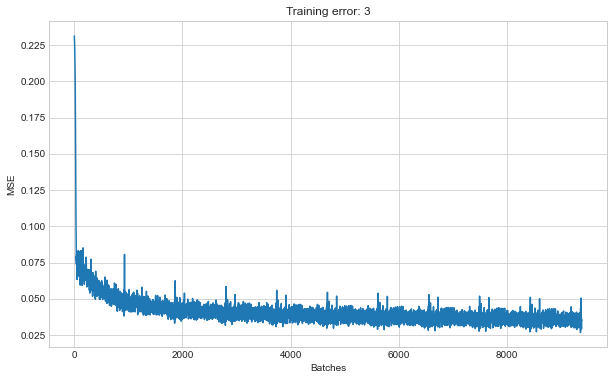

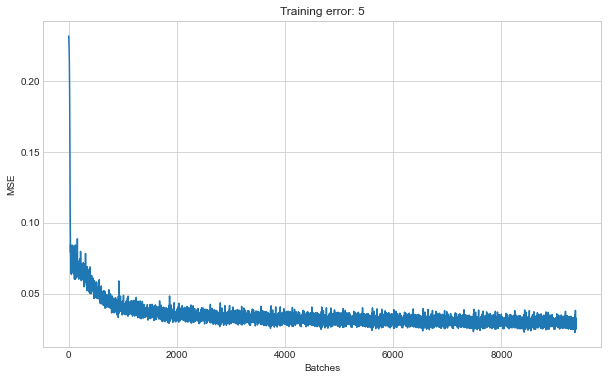

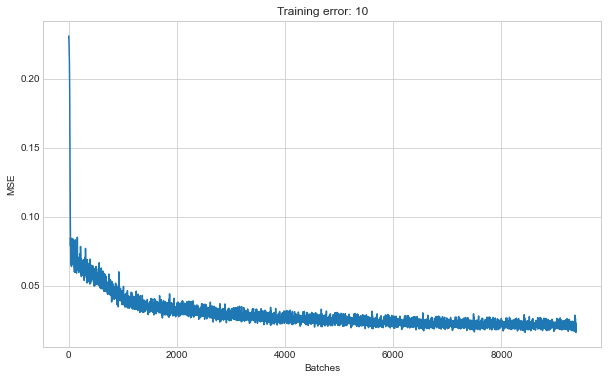

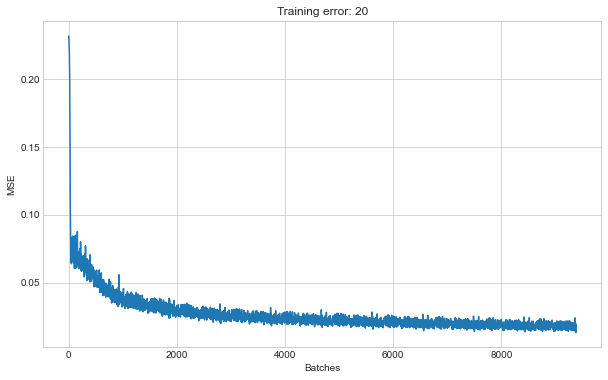

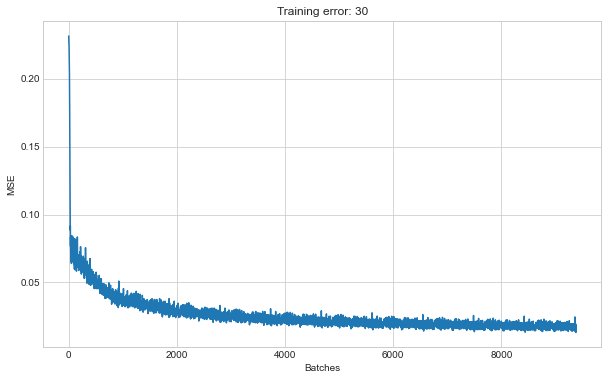

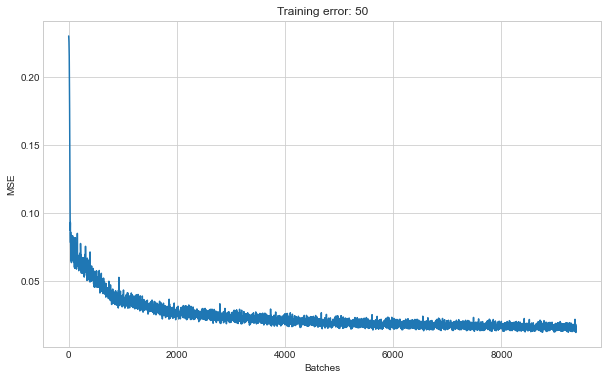

In [4]:
latent_space_dim = [3, 5, 10, 20, 30, 50]
model_path = Path() / "models"
model_path.mkdir(exist_ok=True)

for n_latent in latent_space_dim:
    print(f"training: {n_latent}")
    model_dense = AutoEncoderDense(n_latent=n_latent)
    trainer = pl.Trainer(max_epochs=10)
    trainer.fit(model_dense, mnist_train)
    torch.save(model_dense, model_path / f"dense_{n_latent}.pt")

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(model_dense.train_log)
    ax.set_title(f"Training error: {n_latent}")
    ax.set_xlabel("Batches")
    ax.set_ylabel("MSE")

## Results
We need to get the MSE of all images so we can see how the latent space affects reconstruction error.
For this we reload each network and predict all the training images.

In [5]:
# use whole training dataset
dataloader = torch.utils.data.DataLoader(
    dataset=mnist_train_data, batch_size=len(mnist_train_data)
)
images_all, labels_all = next(iter(dataloader))

# dense model error
mse_train_dense = []
for n_latent in latent_space_dim:
    print(f"mse: {n_latent}")
    model_dense = torch.load(model_path / f"dense_{n_latent}.pt")
    images_all_hat = model_dense(images_all)
    _loss = torch.nn.MSELoss()(images_all_hat, images_all)
    mse_train_dense.append(_loss.detach().numpy())

mse: 3
mse: 5
mse: 10
mse: 20
mse: 30
mse: 50


To examine the results of the networks we will compare against PCA as a baseline.
Here we fit a PCA model as previously shown.
Then we reconstruct the images and measure the MSE at each latent space size.

In [6]:
import numpy as np
import pandas as pd
import sklearn.decomposition
import sklearn.metrics

# convert images to 1D vectors
images_flat = images_all[:, 0].reshape(-1, 784).numpy()
images_flat.shape

print(f"training components: {latent_space_dim[-1]}")
pca = sklearn.decomposition.PCA(n_components=latent_space_dim[-1])
images_flat_hat = pca.inverse_transform(pca.fit_transform(images_flat))


def transform_truncated(pca, X, n_components):
    X = pca._validate_data(X, dtype=[np.float64, np.float32], reset=False)
    if pca.mean_ is not None:
        X = X - pca.mean_
    X_transformed = np.dot(X, pca.components_[:n_components, :].T)
    if pca.whiten:
        X_transformed /= np.sqrt(pca.explained_variance_)
    return X_transformed


def inv_transform(pca, X, n_components):
    return np.dot(X, pca.components_[:n_components, :]) + pca.mean_


def inv_forward_transform(pca, X, n_components):
    return inv_transform(
        pca, transform_truncated(pca, X, n_components), n_components
    )


# get pca mse
mse_train_pca = []
for n_latent in latent_space_dim:
    print(f"mse: {n_latent}")
    images_flat_hat = inv_forward_transform(
        pca, X=images_flat, n_components=n_latent
    )
    _loss = sklearn.metrics.mean_squared_error(images_flat_hat, images_flat)
    mse_train_pca.append(_loss)

training components: 50
mse: 3
mse: 5
mse: 10
mse: 20
mse: 30
mse: 50


Now let's plot the two approaches side by side:

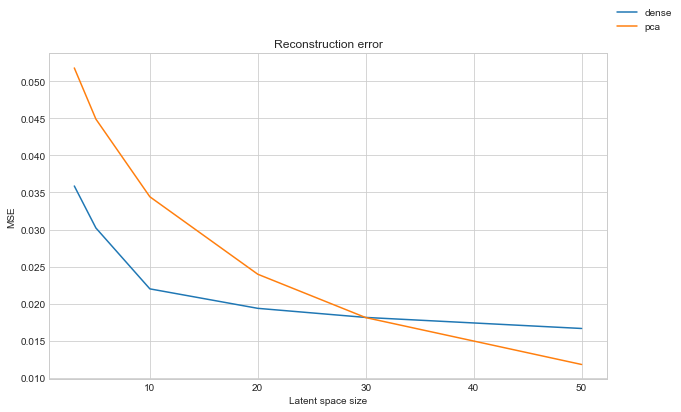

In [7]:
# reconstruction mse
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(latent_space_dim, mse_train_dense, label="dense")
ax.plot(latent_space_dim, mse_train_pca, label="pca")
ax.set_title("Reconstruction error")
ax.set_xlabel("Latent space size")
ax.set_ylabel("MSE")
fig.legend()

We can see that the dense autoencoder does do better generally.
Particularly so at small latent space sizes.
Once the latent space gets much larger PCA becomes comparible.
With a latent space of 50, in the autoencoder this is greater than the output
size of the preceeding layer, hence we dont expect any improvement here.

## Test set
However as noted prior, there are more parameters than images, so we could easily be overfitting here.
To confirm we can check the reconstruction error on the unseen test set.

mse: 3
mse: 5
mse: 10
mse: 20
mse: 30
mse: 50
mse: 3
mse: 5
mse: 10
mse: 20
mse: 30
mse: 50


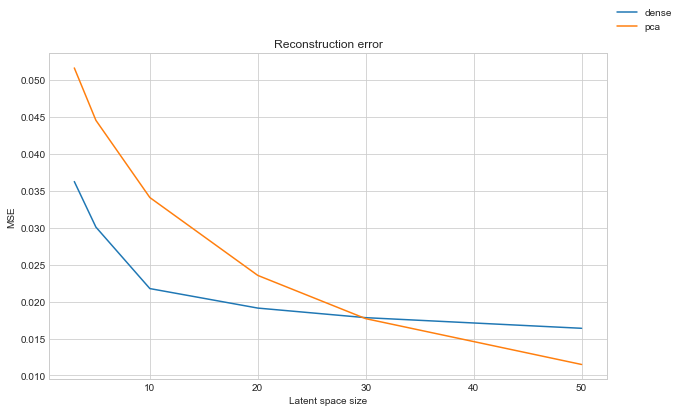

In [8]:
# Run same analysis on test set to check for overfitting

# use whole training dataset
dataloader = torch.utils.data.DataLoader(
    dataset=mnist_test_data, batch_size=len(mnist_test_data)
)
images_all, labels_all = next(iter(dataloader))
images_flat = images_all[:, 0].reshape(-1, 784).numpy()

# autoencoder
mse_test_dense = []
for n_latent in latent_space_dim:
    print(f"mse: {n_latent}")
    model_dense = torch.load(model_path / f"dense_{n_latent}.pt")
    images_all_hat = model_dense(images_all)
    _loss = torch.nn.MSELoss()(images_all_hat, images_all)
    mse_test_dense.append(_loss.detach().numpy())

# pca
mse_test_pca = []
for n_latent in latent_space_dim:
    print(f"mse: {n_latent}")
    images_flat_hat = inv_forward_transform(
        pca, X=images_flat, n_components=n_latent
    )
    _loss = sklearn.metrics.mean_squared_error(images_flat_hat, images_flat)
    mse_test_pca.append(_loss)


# reconstruction mse
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(latent_space_dim, mse_test_dense, label="dense")
ax.plot(latent_space_dim, mse_test_pca, label="pca")
ax.set_title("Reconstruction error")
ax.set_xlabel("Latent space size")
ax.set_ylabel("MSE")
fig.legend()

We obtain very similar results to before.
This gives us a good indication we are not overfitting.
Therefore the autoencoders should generalise to unseen images fine.
For more confidence it would be nice to apply cross validation and get multiple instances of the model and results.
I'll skip this for now in the interests of time.

## Results - images
We have an improvement in MSE but it's good to check the actual reconstructed images to confirm with our eyes.

First for PCA - top row are the originals, subsequent rows are increasing latent space size.

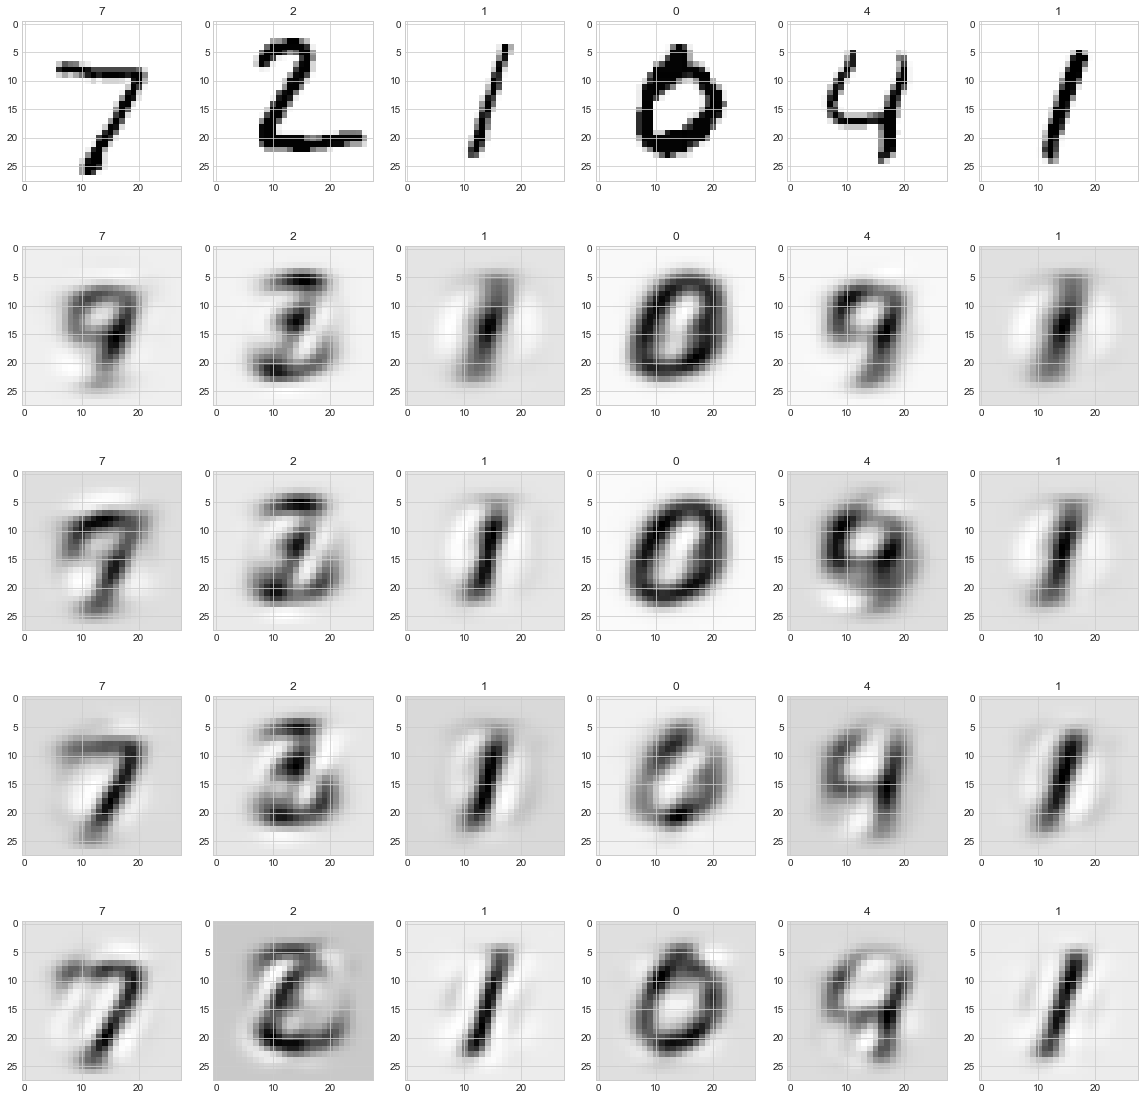

In [9]:
fig, ax = plt.subplots(figsize=(20, 20), ncols=6, nrows=5)

for row, n_latent in enumerate(latent_space_dim[:4]):
    images_hat = inv_forward_transform(
        pca, X=images_flat, n_components=n_latent
    ).reshape(-1, 28, 28)

    for col in range(6):
        ax[0, col].imshow(images_all[col, 0])
        ax[0, col].set_title(str(labels_all[col].numpy()))

        ax[row + 1, col].imshow(images_hat[col])
        ax[row + 1, col].set_title(str(labels_all[col].numpy()))

The same for the autoencoder:

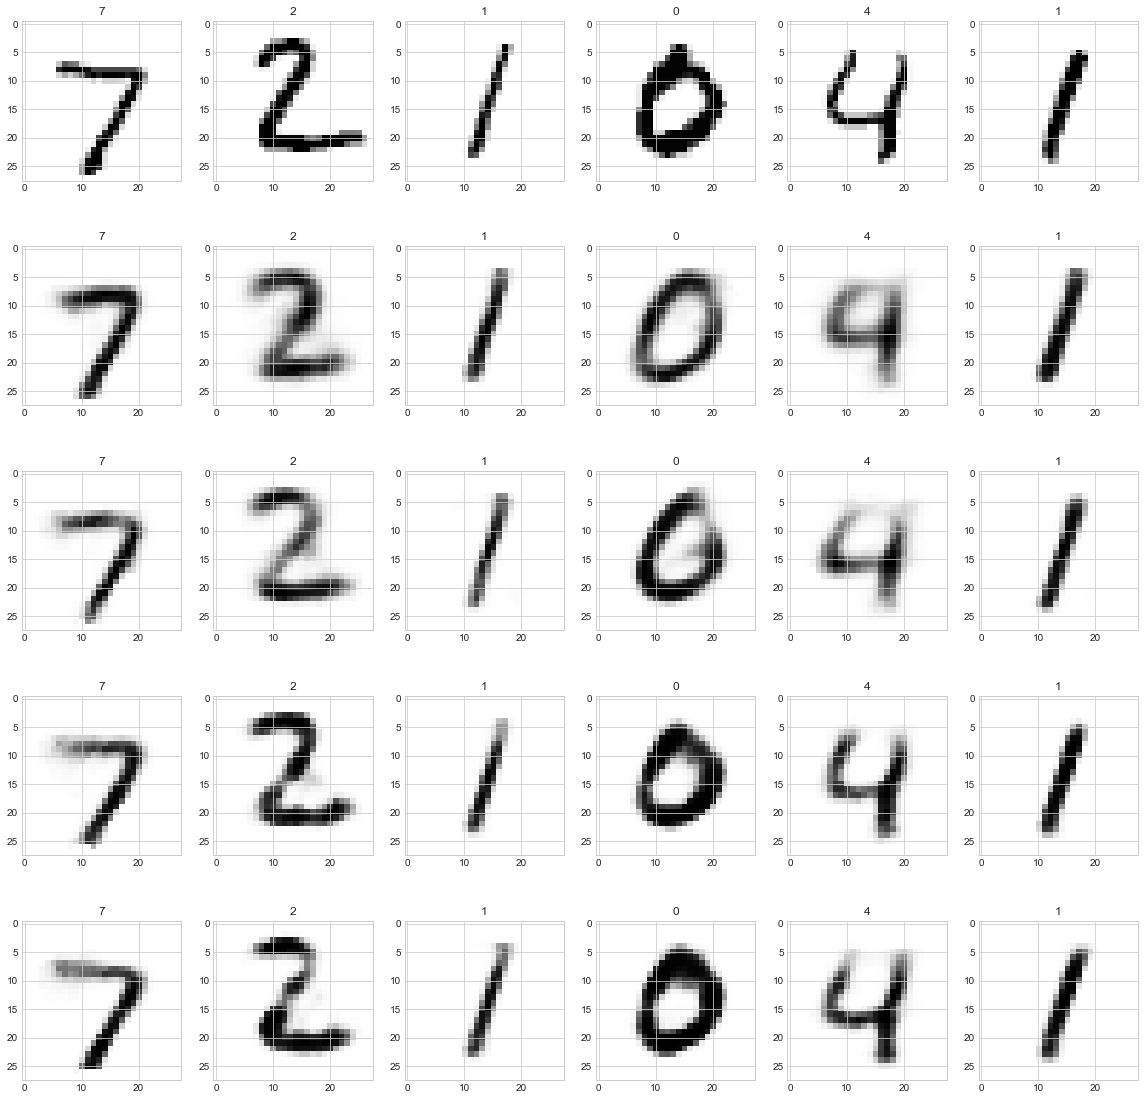

In [10]:
fig, ax = plt.subplots(figsize=(20, 20), ncols=6, nrows=5)

for row, n_latent in enumerate(latent_space_dim[:4]):
    model_dense = torch.load(model_path / f"dense_{n_latent}.pt")
    images_hat = model_dense(images_all).detach()
    
    for col in range(6):
        ax[0, col].imshow(images_all[col, 0])
        ax[0, col].set_title(str(labels_all[col].numpy()))

        ax[row + 1, col].imshow(images_hat[col,0])
        ax[row + 1, col].set_title(str(labels_all[col].numpy()))

We can see that the autoencoder is much clearer at small latent spaces.
Even at only 3, the images are pretty decent.

Similar to PCA, some digits look worse than others.
We can plot the MSE against the digit to see which are hard to construct:

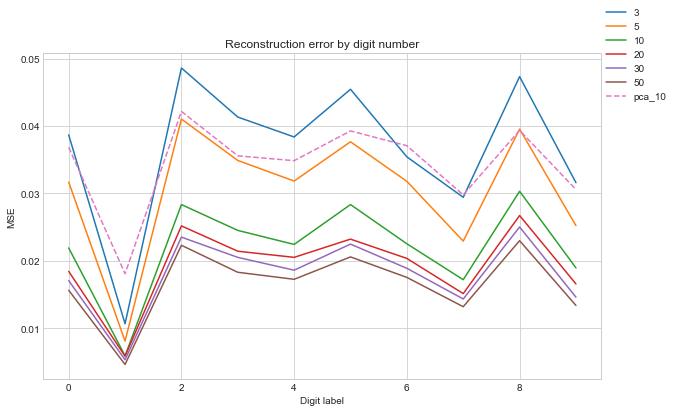

In [11]:
# MSE against label - PCA benchmark
images_flat_hat = inv_forward_transform(
    pca, X=images_flat, n_components=latent_space_dim[2]
)

loss_label_pca = []
for label in range(0, 10):
    filt = labels_all == label
    _loss = sklearn.metrics.mean_squared_error(
        images_flat_hat[filt], images_flat[filt]
    )
    loss_label_pca.append(_loss)

# MSE against label for autoencoder
loss_label = []
for row, n_latent in enumerate(latent_space_dim):
    model_dense = torch.load(model_path / f"dense_{n_latent}.pt")
    images_all_hat = model_dense(images_all)

    _loss_label = []
    for label in range(0, 10):
        filt = labels_all == label
        _loss = torch.nn.MSELoss()(
            images_all_hat[filt].detach(), images_all[filt].detach()
        ).numpy().flatten()[0]
        _loss_label.append(_loss)
    loss_label.append(_loss_label)

# create plot with pca benchmark
df_loss = pd.DataFrame(
    loss_label, index=latent_space_dim, columns=range(0, 10)
).transpose()

fig, ax = plt.subplots(figsize=(10, 6))
df_loss.plot(ax=ax, legend=False)
ax.plot(range(0, 10), loss_label_pca, '--', label=f'pca_{latent_space_dim[2]}')
ax.set_title("Reconstruction error by digit number")
ax.set_xlabel("Digit label")
ax.set_ylabel("MSE")
fig.legend()

The digits the autoencoder struggle with are generally the same as PCA.
We can see the reconstruction error for an autoencoder with 5 latent variables is comparible
to PCA with 10 components.
The autoencoder seems to do better reconstructing '1', '6' and '7'.

There are plenty of hyperparameters to tune with the autoencoder.
For example all the other layer sizes and number of layers.
Indeed we could switch the dense layers out for convolution layers...

Another thought, it should be fairly easy to train a digit classifier on the latent representation of the images.